# Potato Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=28

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5702 files belonging to 6 classes.


**Watch below video on tensorflow input pipeline first if you don't know about tensorflow datasets**

In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'xyz',
 'xyz2',
 'xyz3']

In [5]:

68*32 ## there are 32 batches

2176

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 2 1 1 2 2 0 2 0 2 2 1 2 0 2 0 0 1 2 0 0 0 2 1 1 2 0 0 2 0 2 0]


tf.Tensor(
[[[140. 130. 129.]
  [145. 135. 134.]
  [126. 116. 115.]
  ...
  [145. 136. 141.]
  [144. 135. 140.]
  [125. 116. 121.]]

 [[145. 135. 134.]
  [147. 137. 136.]
  [126. 116. 115.]
  ...
  [158. 149. 154.]
  [211. 202. 207.]
  [158. 149. 154.]]

 [[141. 131. 130.]
  [147. 137. 136.]
  [129. 119. 118.]
  ...
  [146. 137. 142.]
  [148. 139. 144.]
  [135. 126. 131.]]

 ...

 [[145. 139. 141.]
  [147. 141. 143.]
  [149. 143. 145.]
  ...
  [159. 153. 157.]
  [158. 152. 156.]
  [158. 152. 156.]]

 [[142. 136. 138.]
  [145. 139. 141.]
  [148. 142. 144.]
  ...
  [158. 152. 156.]
  [157. 151. 155.]
  [158. 152. 156.]]

 [[143. 137. 139.]
  [148. 142. 144.]
  [152. 146. 148.]
  ...
  [156. 150. 154.]
  [156. 150. 154.]
  [158. 152. 156.]]], shape=(256, 256, 3), dtype=float32)
[[[140. 130. 129.]
  [145. 135. 134.]
  [126. 116. 115.]
  ...
  [145. 136. 141.]
  [144. 135. 140.]
  [125. 116. 121.]]

 [[145. 135. 134.]
  [147. 137. 136.]
  [126. 116. 115.]
  ...
  [158. 149. 154.]
  [211. 20

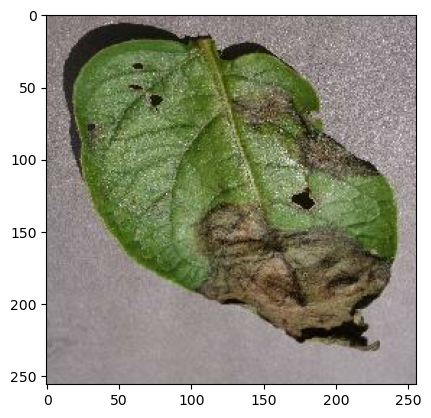

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0])##first image in tensor
    print(image_batch[0].numpy()) ## tensor to numpy
    print(image_batch[0].shape)
    plt.imshow(image_batch[0].numpy().astype("uint8"))## to visualise the first image
    

As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

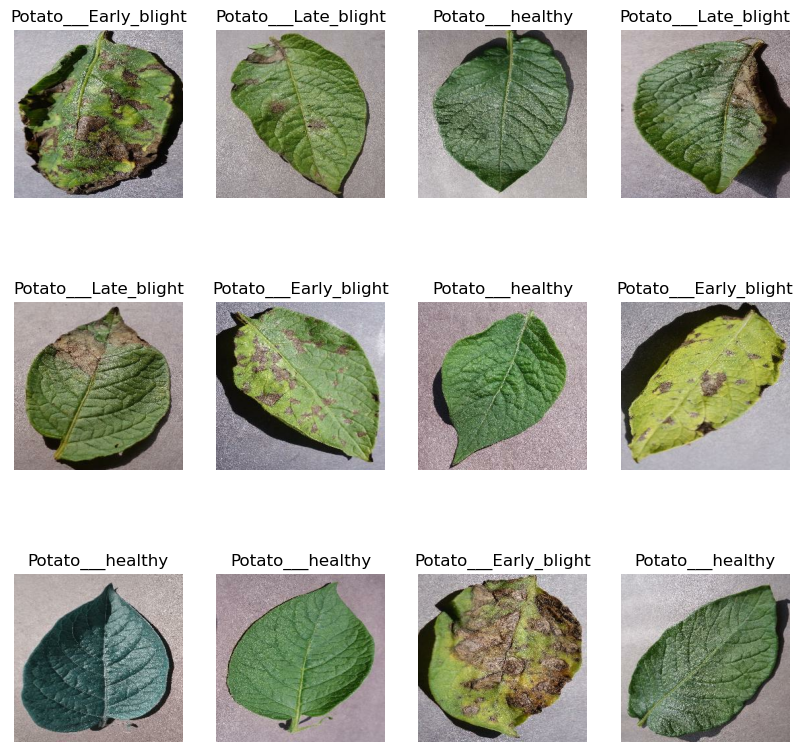

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):## showing the diff images
        ax = plt.subplot(3, 4, i + 1)## the way we are showing the images this func is for it
        plt.imshow(image_batch[i].numpy().astype("uint8"))## imges_bacth is actually using the single batch images 
        plt.title(class_names[labels_batch[i]])## this shows the disease actually by using the class name
        
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [9]:
len(dataset)

179

In [10]:
## 80% traning
##20%= 10%validation(used during training )+10% test(for accuracy of our model)
## after each epoch we do validation on this 10% data


In [11]:
train_size = 0.8
len(dataset)*train_size

143.20000000000002

In [12]:
train_ds = dataset.take(54)## first 54
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)##after 54
len(test_ds)

125

In [14]:
val_size=0.1 ## validation size
len(dataset)*val_size

17.900000000000002

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

119

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

143

In [20]:
len(val_ds)

17

In [21]:
len(test_ds)

19

### Cache, Shuffle, and Prefetch the Dataset

In [22]:
##this will read the image from the disk and then for the next iteration when you need the same image it will keep that image in the memory.
## this improves the performance of our pipeline again

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)## if gpu is busy then prefatch will load the next batch of our disk that will improves the per formance
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [24]:
## lets say our image is not 256 /256 then this resize and rescale will change it to 256/256
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),## diving it by 255 so that we get the number between 0 and 1
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [25]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [26]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



**Watch below video if you are not familiar with data augmentation**

In [27]:
HTML("""
<iframe width="560" height="315" src="https://www.youtube.com/embed/mTVf7BN7S8w" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
""")

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN**

In [28]:
HTML("""
<iframe width="560" height="315" src="https://www.youtube.com/embed/zfiSAzpy9NM" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
""")

In [29]:
## different types of layers we are  using in our model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
     layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
143/143 [==============================] - 1128s 6s/step - loss: 0.9563 - accuracy: 0.4732 - val_loss: 0.7762 - val_accuracy: 0.6507
Epoch 2/50
143/143 [==============================] - 492s 3s/step - loss: 0.5589 - accuracy: 0.7629 - val_loss: 0.7576 - val_accuracy: 0.7647
Epoch 3/50
143/143 [==============================] - 419s 3s/step - loss: 0.3439 - accuracy: 0.8684 - val_loss: 0.2841 - val_accuracy: 0.8860
Epoch 4/50
143/143 [==============================] - 415s 3s/step - loss: 0.2327 - accuracy: 0.9178 - val_loss: 0.8017 - val_accuracy: 0.8327
Epoch 5/50
143/143 [==============================] - 414s 3s/step - loss: 0.1892 - accuracy: 0.9420 - val_loss: 0.0808 - val_accuracy: 0.9688
Epoch 6/50
143/143 [==============================] - 409s 3s/step - loss: 0.0691 - accuracy: 0.9754 - val_loss: 0.1394 - val_accuracy: 0.9522
Epoch 7/50
143/143 [==============================] - 414s 3s/step - loss: 0.0581 - accuracy: 0.9780 - val_loss: 0.1305 - val_accuracy: 0.955

In [60]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 445ms/step - loss: 2.4068e-05 - accuracy: 1.0000


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [62]:
scores

[2.406847670499701e-05, 1.0]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [68]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [64]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [65]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [66]:
type(history.history['loss'])

list

In [67]:
len(history.history['loss'])

50

In [69]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8947528004646301,
 0.7373615503311157,
 0.6000609993934631,
 0.4967658519744873,
 0.424297958612442]

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

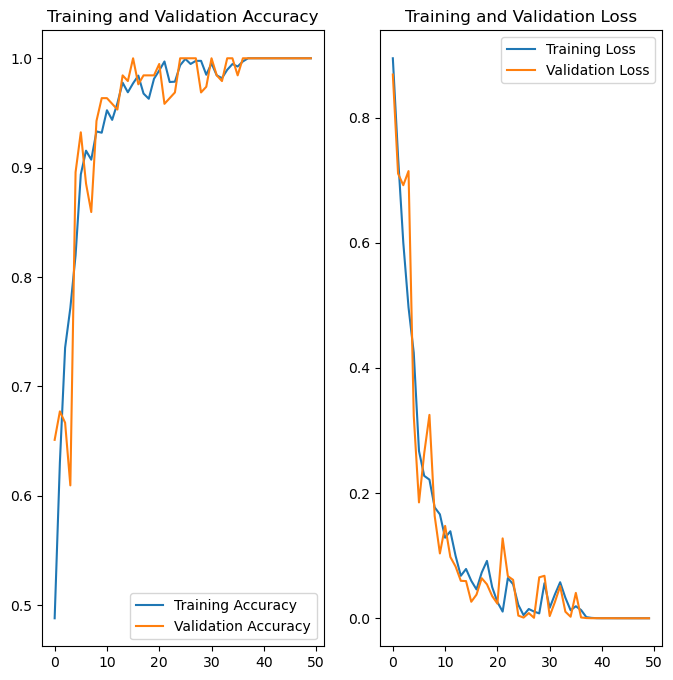

In [71]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 887ms/step
predicted label: Potato___Late_blight


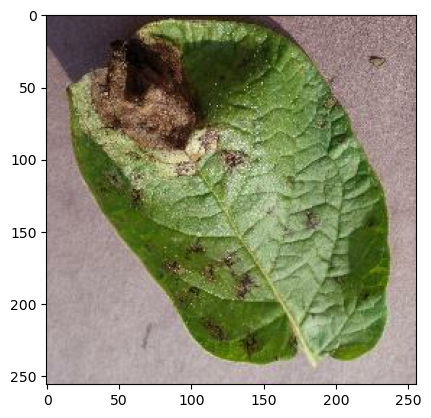

In [72]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [73]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 47ms/step


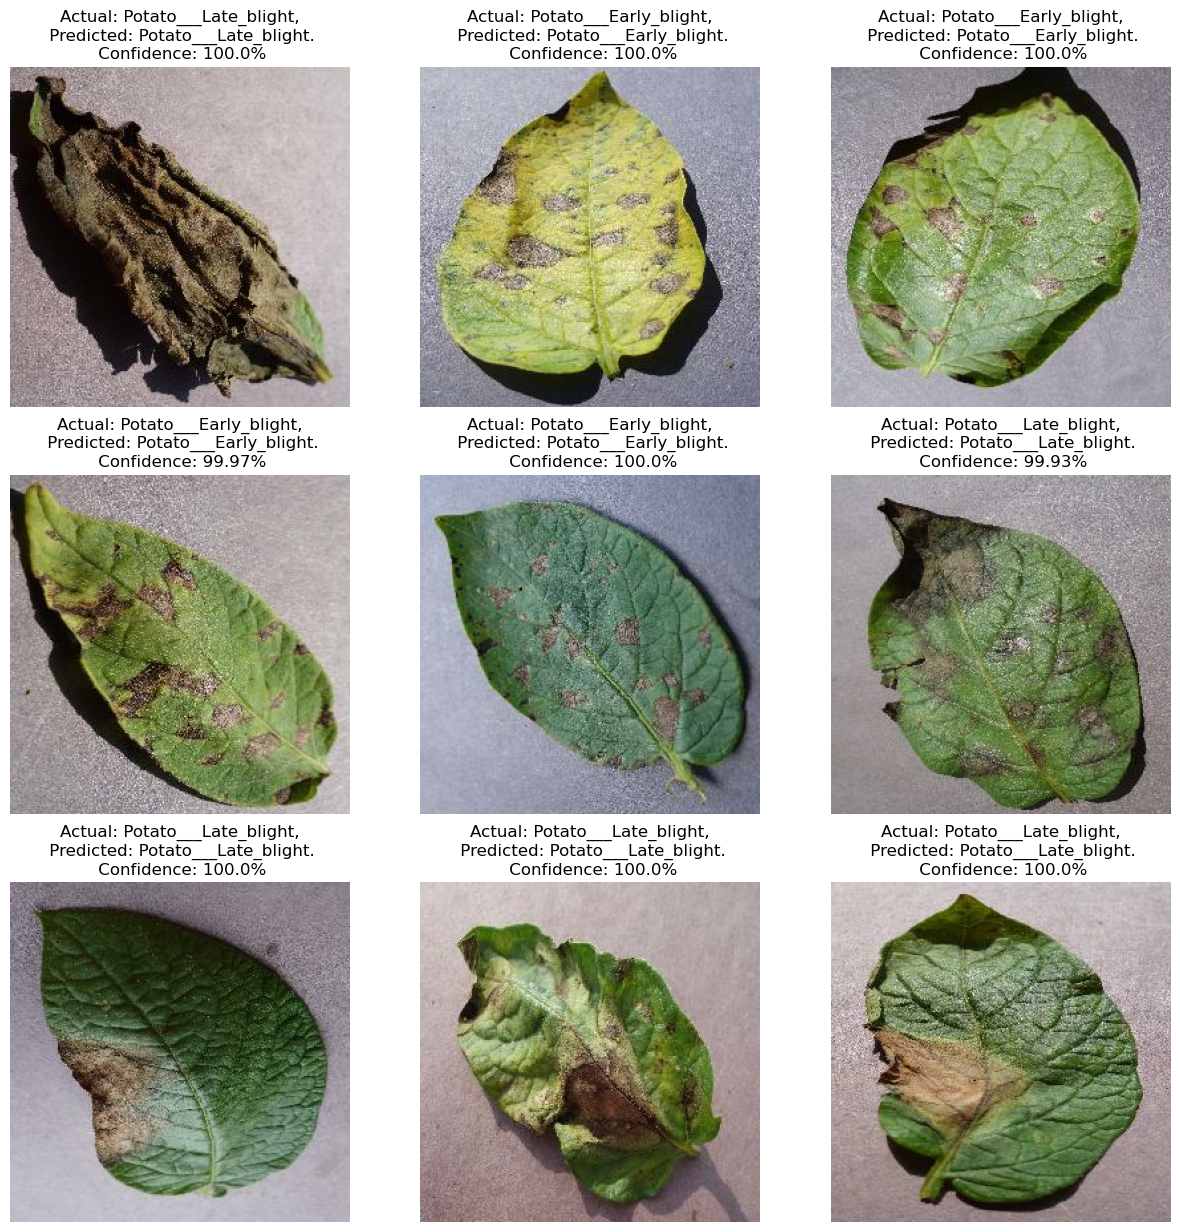

In [74]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [6]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../models'

In [48]:
model.save("../potatoes.h5")